# Wstęp do multimediów (WMM)
### Kacper Górski, 331379


In [2]:
from matplotlib import pyplot as plt
from IPython.display import display, Markdown
import cv2
import numpy as np
from wlasciwosci_obrazow import printi, calc_entropy, dwt, calc_mse_psnr
import os

Image index to process:  35
image_col, wymiary: (480, 720, 3), typ danych: uint8, wartości: 12 - 255


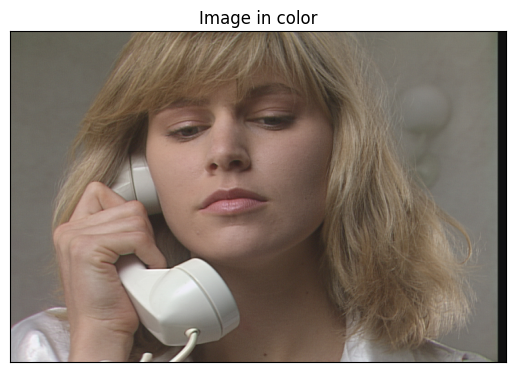

image, wymiary: (480, 720, 3), typ danych: uint8, wartości: 15 - 253


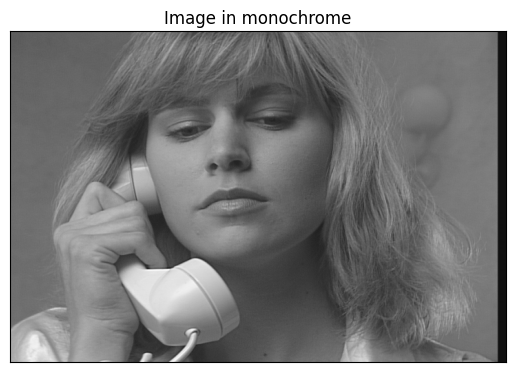

In [3]:
NUM_IMAGES = 36
STUDENT_INDEX = 331379

def image_to_process(student_index, num_images):
    return student_index % num_images

print("Image index to process: ", image_to_process(STUDENT_INDEX, NUM_IMAGES))

IMAGE_PATH_COL = os.path.join(os.getcwd(), "image", "susie_col.png")
IMAGE_PATH_MONO = os.path.join(os.getcwd(), "image", "susie_mono.png")

def load_image(path):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plt_imshow(img, img_title="image", cmap = False):
    plt.figure()
    plt.title(img_title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else: plt.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

def generate_histogram(image, size):
    hist = cv2.calcHist([image], [0], None, [size], [0, size])
    hist = hist.flatten()
    return hist


image_col = load_image(IMAGE_PATH_COL)
printi(image_col, "image_col")
plt_imshow(image_col, "Image in color")

image_mono = load_image(IMAGE_PATH_MONO)
printi(image_mono, "image")
plt_imshow(image_mono, "Image in monochrome")

### Obraz do przetworzenia -> susie_col.png (index: 35)

## Dla obrazu monochromatycznego: 

- Obliczyć entropię obrazu wejściowego.   

In [4]:
def scale_for_display(img, is_dwt=False):
    """Normalizacja obrazu do wyświetlania"""
    if is_dwt:
        img_abs = np.abs(img)
        return cv2.normalize(img_abs, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

hist_mono = cv2.calcHist([image_mono], [0], None, [256], [0, 256]).flatten()
mono_entropy = calc_entropy(hist_mono)
print("Entropia obrazu monochromatycznego: ", mono_entropy)

Entropia obrazu monochromatycznego:  7.000969


- Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą 
pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe /. 
predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa 
wartość przedziału zmienności wartości pikseli).     
Wyświetlić obraz różnicowy.     
Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.   
Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.   
Uwaga: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]!   

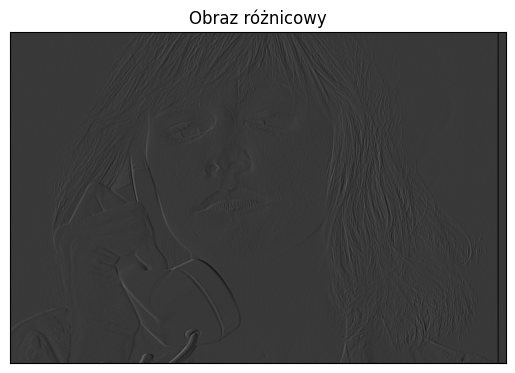

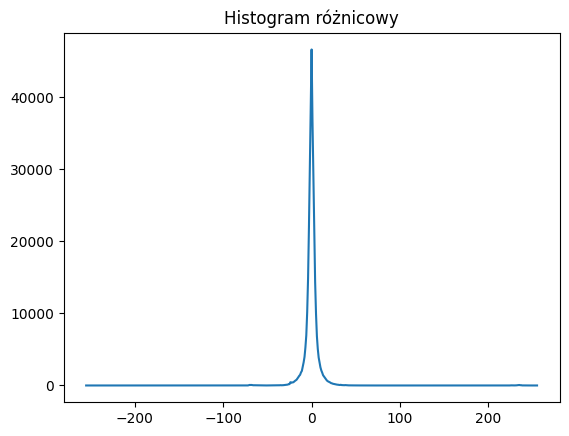

Entropia różnicowa: 4.4032 bits/piksel


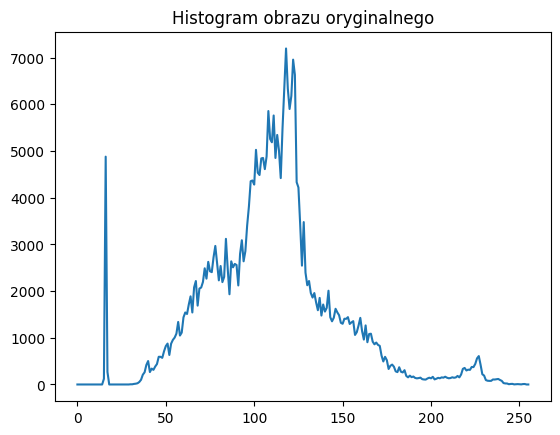

Entropia obrazu oryginalnego: 7.0010 bits/piksel


In [5]:
def create_diff_image(img):
    PIXEL_VALUE = 127

    diff = np.zeros_like(img, dtype=np.int16)
    diff[:,0] = img[:,0] - PIXEL_VALUE
    diff[:,1:] = img[:,1:].astype(np.int16) - img[:,:-1].astype(np.int16)
    return diff

image_diff = create_diff_image(image_mono)

plt_imshow(scale_for_display(image_diff), "Obraz różnicowy", "gray")

hist_diff = cv2.calcHist([image_diff.astype(np.float32)], [0], None, [511], [-255, 256]).flatten()
plt.figure()
plt.plot(np.linspace(-255, 255, 511), hist_diff)
plt.title("Histogram różnicowy")
plt.show()

diff_entropy = calc_entropy(hist_diff)
print(f"Entropia różnicowa: {diff_entropy:.4f} bits/piksel")

plt.figure()
plt.plot(hist_mono)
plt.title("Histogram obrazu oryginalnego")
plt.show()

print(f"Entropia obrazu oryginalnego: {mono_entropy:.4f} bits/piksel")

- Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.  
Wyświetlić poszczególne pasma.   
Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.   
Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą (czy któreś 
się wyróżniają i dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu 
różnicowego.    
Uwaga: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!    

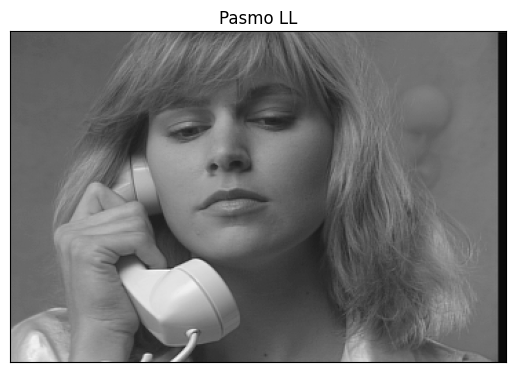

band_LL, wymiary: (240, 360), typ danych: uint8, wartości: 7 - 255


**Entropia pasma LL:** 6.9940

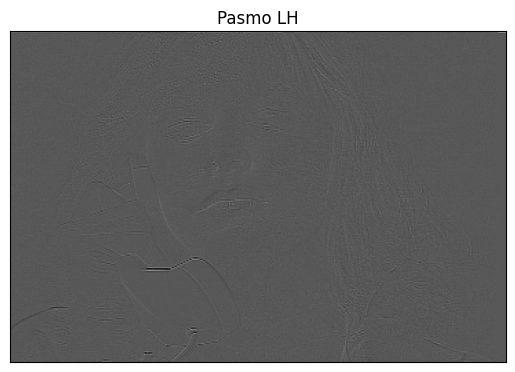

band_LH, wymiary: (240, 360), typ danych: int16, wartości: -66 - 125


**Entropia pasma LH:** 2.6227

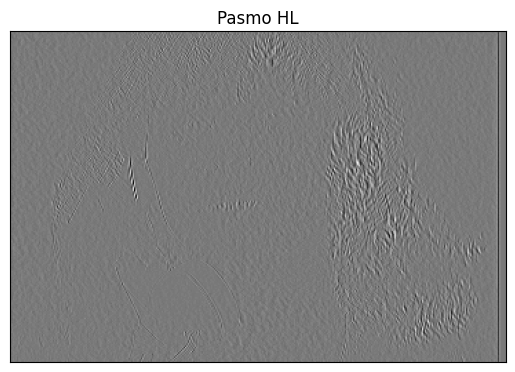

band_HL, wymiary: (240, 360), typ danych: int16, wartości: -41 - 45


**Entropia pasma HL:** 2.9854

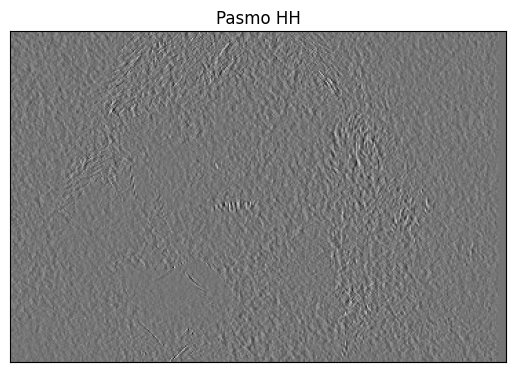

band_HH, wymiary: (240, 360), typ danych: int16, wartości: -29 - 34


**Entropia pasma HH:** 3.1790

In [6]:
image_mono = cv2.imread(IMAGE_PATH_MONO, cv2.IMREAD_GRAYSCALE)
assert image_mono.ndim == 2, "Image should be grayscale"

bands = dwt(image_mono)
band_names = ["LL", "LH", "HL", "HH"]
entropies = []

def compute_band_entropy(band):
    band_abs = cv2.convertScaleAbs(band)
    hist = cv2.calcHist([band_abs], [0], None, [256], [0, 256])
    return hist, calc_entropy(hist)

for band, band_name in zip(bands, band_names):
    band_hist, band_entropy = compute_band_entropy(band)
    entropies.append(band_entropy)

    plt_imshow(scale_for_display(band), "Pasmo " + band_name, cmap="gray")
    printi(band, "band_" + band_name)
    display(Markdown(f"**Entropia pasma {band_name}:** {band_entropy[0]:.4f}"))


- Transformacja falkowa podzieliła obraz na cztery pasma: LL, LH, HL, HH. Pasmo LL reprezentuje niskoczęstotliwościową zawartość obrazu (ogólną strukturę), natomiast pozostałe pasma zawierają informacje o szczegółach w różnych kierunkach.

- Entropia pasma LL była najwyższa, co wynika z faktu, że zawiera ono najwięcej informacji istotnych dla postrzegania obrazu.

- Pasma LH, HL i HH charakteryzowały się niższą entropią, co oznacza mniejszą ilość informacji lub większą redundancję, a tym samym większy potencjał do kompresji.

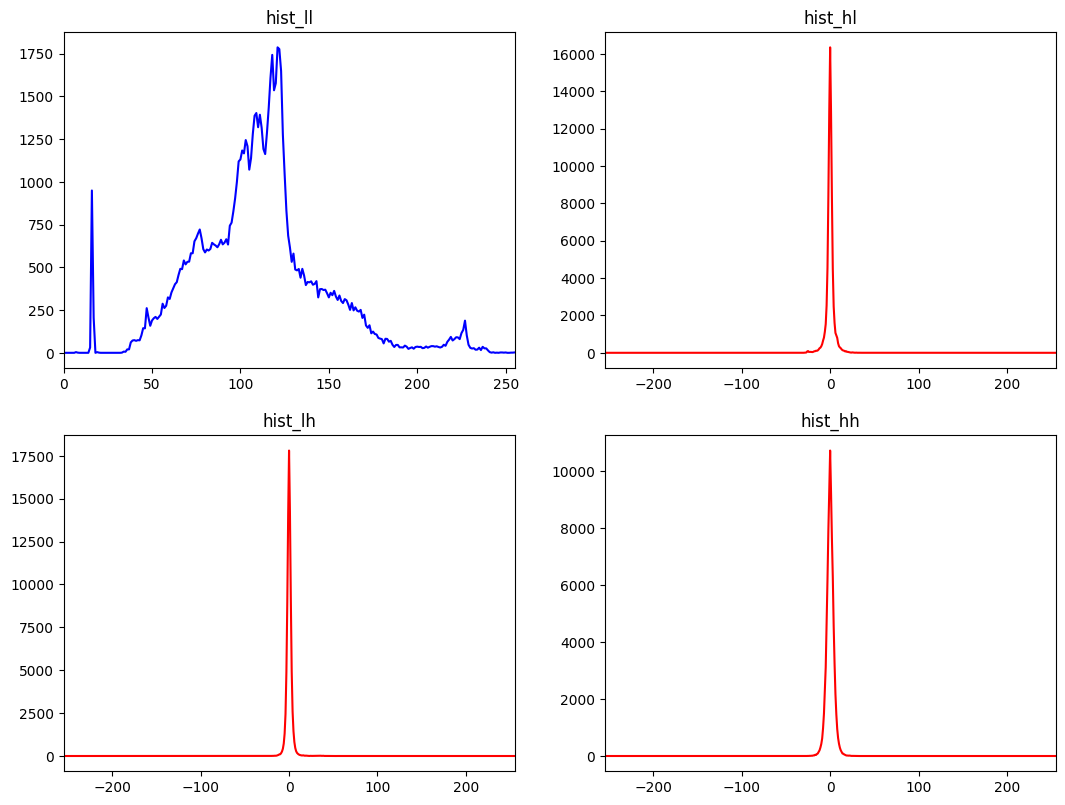

H(LL) = 6.9940 
H(LH) = 3.4145 
H(HL) = 3.7946 
H(HH) = 4.0544 
H_śr = 14.203038215637207
H(image_mono) = 7.0010
H(hdiff) = 4.4032


In [7]:
(ll, lh, hl, hh) = bands

hist_ll = generate_histogram(ll, 256)
# zmiana zakresu wartości i typu danych ze względu na cv2.calcHist() (jak wcześniej przy obrazach różnicowych)
hist_lh = generate_histogram((lh + 255).astype(np.uint16), 511)
hist_hl = generate_histogram((hl + 255).astype(np.uint16), 511)
hist_hh = generate_histogram((hh + 255).astype(np.uint16), 511)
""" Wyświetlenie histogramów - jeden obraz z czterema pod-obrazami """
fig = plt.figure()
fig.set_figheight(fig.get_figheight() * 2) # zwiększenie rozmiarów okna
fig.set_figwidth(fig.get_figwidth() * 2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("hist_ll")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("hist_lh")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("hist_hl")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("hist_hh")
plt.xlim([-255, 255])
plt.show()

H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)

print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll + H_lh + H_hl)}")
print(f"H(image_mono) = {mono_entropy:.4f}")
print(f"H(hdiff) = {calc_entropy(hist_diff):.4f}")

- Obliczyć przepływność (liczbę bitów przypadającą na jeden piksel) dla obrazu skompresowanego 
koderem PNG (obraz wejściowy) i porównać ją z obliczonymi uprzednio entropiami obrazu 
oryginalnego, różnicowego i falokowego. Czy przepływność mniejsza od entropii oznacza, że 
zależność: lśr ≥ H jest nieprawdziwa?

In [8]:
def calc_bitrate(img, size):
    return (size * 8) / (img.shape[0] * img.shape[1])

def calc_png_size(img_path):
    return os.path.getsize(img_path)

png_size = calc_png_size(IMAGE_PATH_MONO)
png_bitrate = calc_bitrate(image_mono, png_size)

print(f"Rozmiar PNG: {png_size} bajtów")
print(f"Bitrate PNG: {png_bitrate:.4f} bpp")

print(f"Oryginał: {mono_entropy:.2f} | Różnicowy: {diff_entropy:.2f} | DWT średnia: {np.mean(entropies):.2f}")

Rozmiar PNG: 192017 bajtów
Bitrate PNG: 4.4448 bpp
Oryginał: 7.00 | Różnicowy: 4.40 | DWT średnia: 3.95


- Przepływność obrazu skompresowanego koderem PNG była mniejsza niż entropia obrazu oryginalnego, co może wydawać się sprzeczne z twierdzeniem Shannona (lśr ≥ H). Jednak jest to zgodne z teorią, ponieważ entropia została obliczona dla nieprzekształconych danych pikseli, natomiast PNG stosuje m.in. predykcję i kompresję bezstratną, co zmienia model źródła informacji.

- Oznacza to, że kompresja może być bardziej efektywna niż prosty model entropii sugeruje, jeśli zastosowane zostaną dodatkowe techniki przetwarzania danych wejściowych.

## Dla obrazu barwnego:

- Obliczyć entropię dla składowych RGB barwnego obrazu testowego.

Entropia R: 7.0322


/tmp/ipykernel_58601/2276479804.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Entropia {channel}: {float(entropies_rgb[-1]):.4f}")


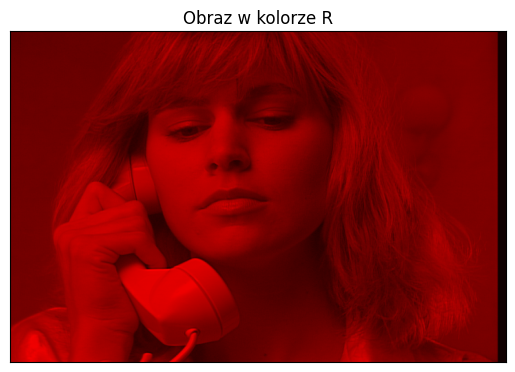

Entropia G: 7.0014


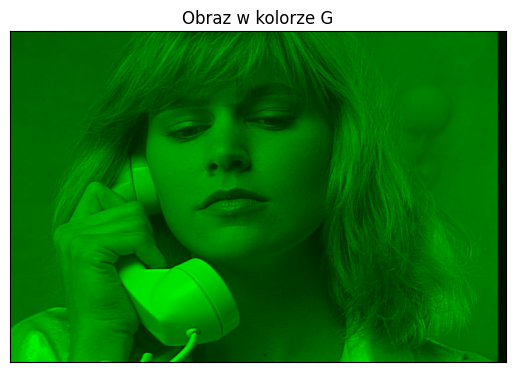

Entropia B: 7.0370


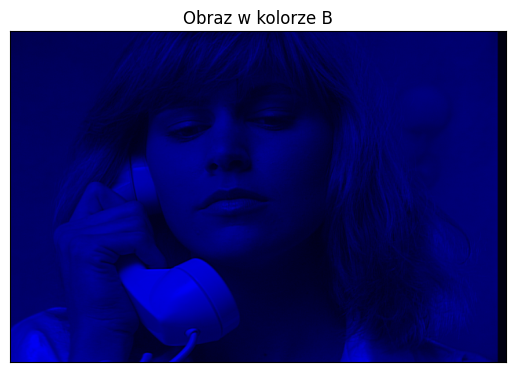

In [9]:
def extract_bgr_channel_from_image(image, color):
    image_ = np.zeros(image.shape).astype(np.uint8)
    image_[:, :, color] = image[:, :, color]
    return image_


entropies_rgb = []
hists_rgb = []
for i, channel in enumerate(['R', 'G', 'B']):
    hist = cv2.calcHist([image_col[:,:,i]], [0], None, [256], [0, 256])
    entropies_rgb.append(calc_entropy(hist))
    hists_rgb.append(hist)

    print(f"Entropia {channel}: {float(entropies_rgb[-1]):.4f}")
    plt_imshow(extract_bgr_channel_from_image(image_col, i), f"Obraz w kolorze {channel}")



- Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV. Wyświetlić składowe 
RGB i YUV.  
Wyznaczyć histogramy dla wszystkich składowych RGB i YUV.   
Porównać wyniki uzyskane dla poszczególnych składowych. Czy dla składowych UV entropia jest 
mniejsza? Z czego ta mniejsza wartość może wynikać? 

Entropia Y: 6.9753


/tmp/ipykernel_58601/72483143.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Entropia {channel}: {float(entropies_yuv[-1]):.4f}")


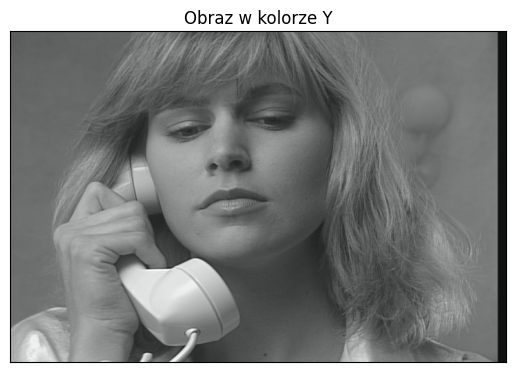

Entropia U: 3.8968


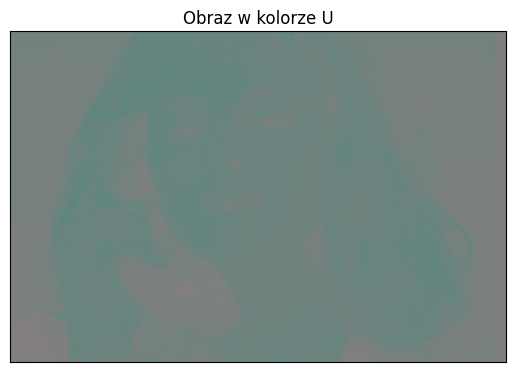

Entropia V: 4.3195


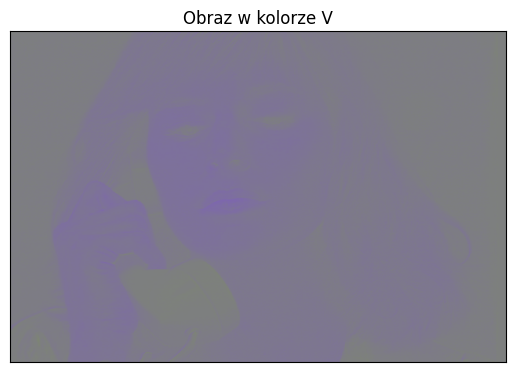

In [10]:
image_col_yuv = cv2.cvtColor(image_col, cv2.COLOR_RGB2YUV)
entropies_yuv = []
hists_yuv = []

def extract_uv_channel_from_image_and_convert_to_bgr(image, color):
    image_ = np.full(image.shape, 127).astype(np.uint8)
    image_[:, :, color] = image[:, :, color]
    return cv2.cvtColor(image_, cv2.COLOR_YUV2BGR)

for i, channel in enumerate(['Y', 'U', 'V']):
    hist = cv2.calcHist([image_col_yuv[:,:,i]], [0], None, [256], [0, 256])
    entropies_yuv.append(calc_entropy(hist))
    hists_yuv.append(hist)

    print(f"Entropia {channel}: {float(entropies_yuv[-1]):.4f}")
    plt_imshow(extract_uv_channel_from_image_and_convert_to_bgr(image_col_yuv, i), f"Obraz w kolorze {channel}")

- Składowe RGB miały porównywalną entropię, choć nieznaczne różnice mogły wynikać z charakterystyki obrazu.

- Po konwersji do przestrzeni YUV, entropia składowych U i V była istotnie niższa niż dla składowej Y, co sugeruje mniejszą ilość informacji w kanałach chrominancji.

- Zjawisko to jest wykorzystywane w kompresji stratnej (np. JPEG), gdzie kanały UV mogą być próbkowane rzadziej bez znaczącej utraty jakości wizualnej.

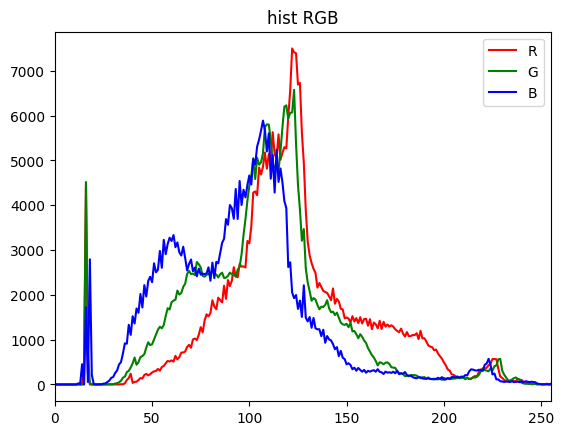

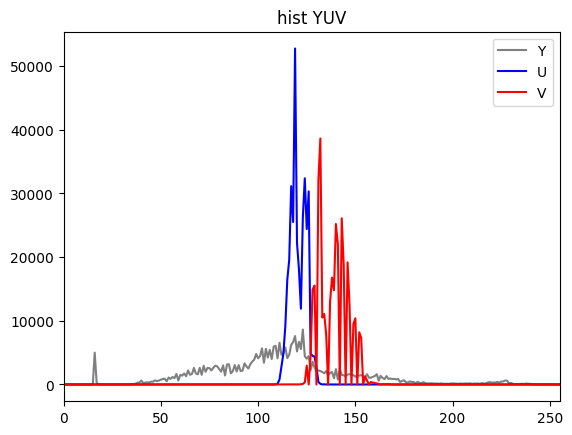

In [11]:
plt.figure()
plt.plot(hists_rgb[0], color="red")
plt.plot(hists_rgb[1], color="green")
plt.plot(hists_rgb[2], color="blue")
plt.title("hist RGB")
plt.legend(["R", "G", "B"])
plt.xlim([0, 255])
plt.show()
plt.plot(hists_yuv[0], color="gray")
plt.plot(hists_yuv[1], color="blue")
plt.plot(hists_yuv[2], color="red")
plt.title("hist YUV")
plt.legend(["Y", 'U', 'V'])
plt.xlim([0, 255])
plt.show()

- Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden 
piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG.   
Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru 
‘quality’ przy zapisie obrazu do pliku. Wartości parametru ‘quality’ należy dobrać tak, aby uzyskać 
‘gładkie’ wykresy.   
Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd 
średniokwadratowy MSE.   
Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).   
Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość 
doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia 
niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny 
w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej ‘zgrupować’ oceny 
dla pewnych zakresów przepływności).   
Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla 
kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był 
monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego; 
ewentualnie obliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

Jakość: 100 | Rozmiar: 242021 bajtów | MSE: 1.79 | PSNR: 45.60 dB | Bitrate: 5.6023 bpp


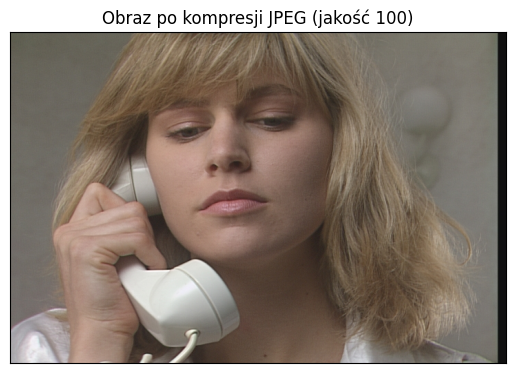

Doskonała
Jakość: 90 | Rozmiar: 64497 bajtów | MSE: 6.26 | PSNR: 40.17 dB | Bitrate: 1.4930 bpp


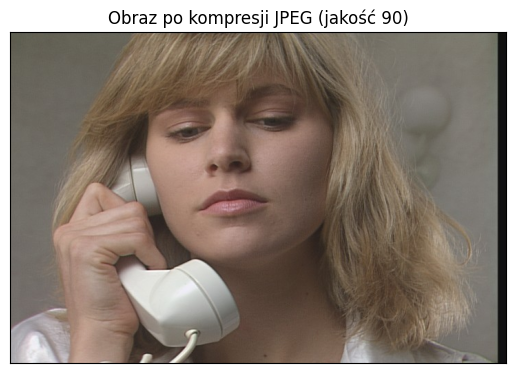

Bardzo dobra
Jakość: 80 | Rozmiar: 40666 bajtów | MSE: 8.70 | PSNR: 38.73 dB | Bitrate: 0.9413 bpp


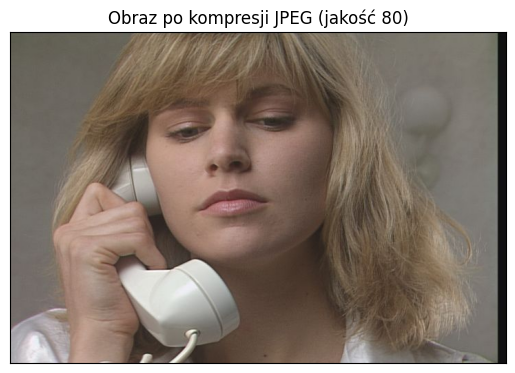

Dobra
Jakość: 70 | Rozmiar: 31281 bajtów | MSE: 10.75 | PSNR: 37.82 dB | Bitrate: 0.7241 bpp


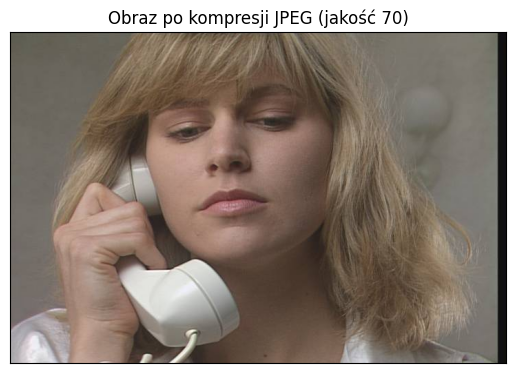

Dobra
Jakość: 60 | Rozmiar: 25909 bajtów | MSE: 12.72 | PSNR: 37.09 dB | Bitrate: 0.5997 bpp


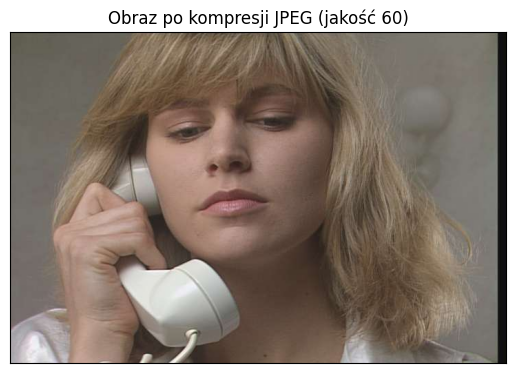

Dobra
Jakość: 50 | Rozmiar: 22581 bajtów | MSE: 14.42 | PSNR: 36.54 dB | Bitrate: 0.5227 bpp


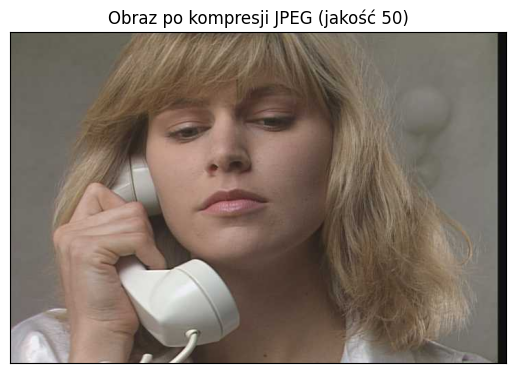

Dobra
Jakość: 40 | Rozmiar: 19576 bajtów | MSE: 16.60 | PSNR: 35.93 dB | Bitrate: 0.4531 bpp


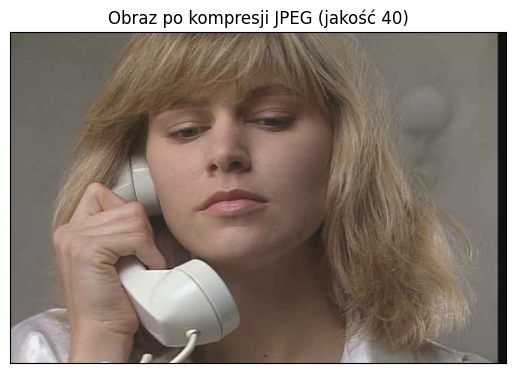

Dobra
Jakość: 30 | Rozmiar: 16568 bajtów | MSE: 21.05 | PSNR: 34.90 dB | Bitrate: 0.3835 bpp


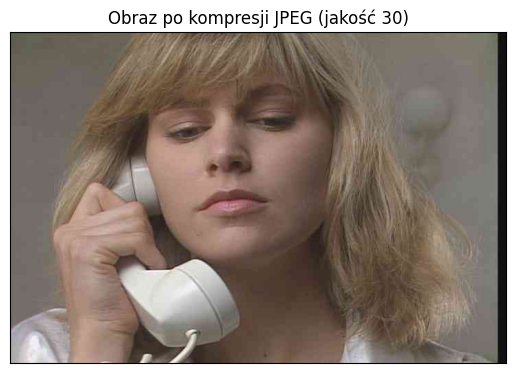

Niska
Jakość: 20 | Rozmiar: 13045 bajtów | MSE: 28.73 | PSNR: 33.55 dB | Bitrate: 0.3020 bpp


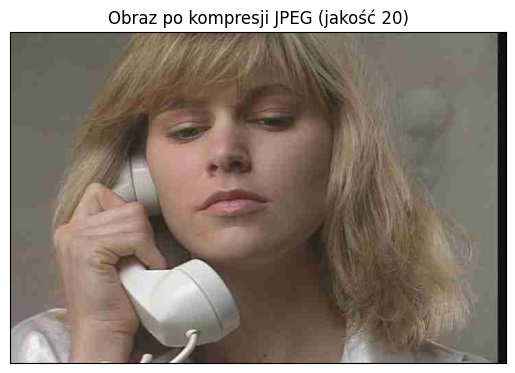

Niska
Jakość: 10 | Rozmiar: 9228 bajtów | MSE: 57.04 | PSNR: 30.57 dB | Bitrate: 0.2136 bpp


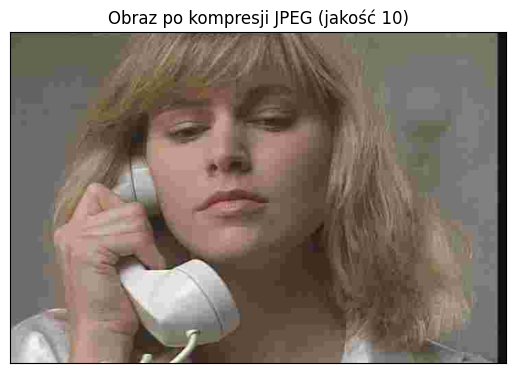

Niska


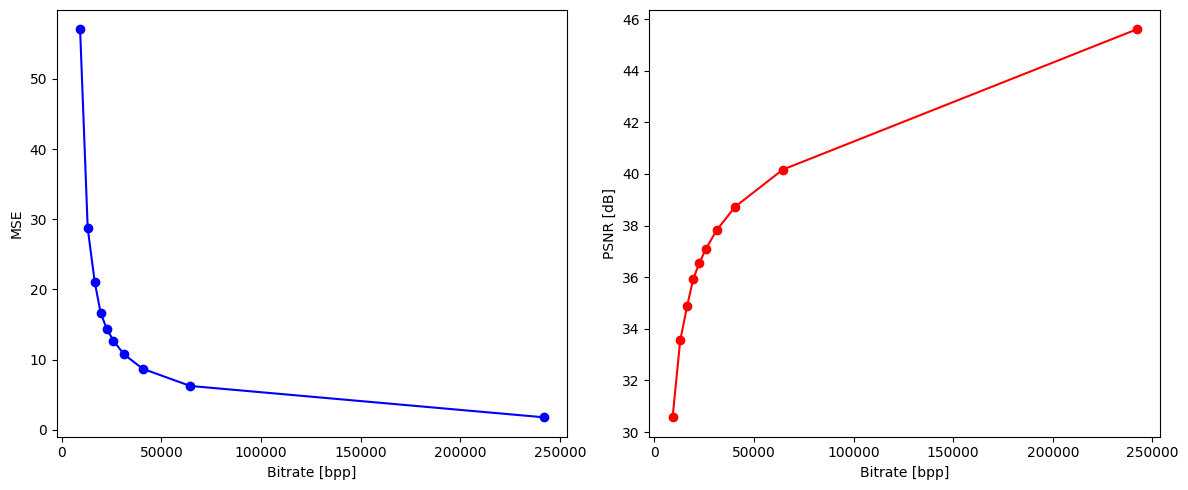


Bitrate PNG (kolor): 12.14 bpp


In [12]:
qualities = np.arange(100, 0, -10)
results = []

TEMP_IMG_PATH = os.path.join(os.getcwd(), "image", "temp.jpg")
quality_label = ""

for quality in qualities:
    cv2.imwrite(TEMP_IMG_PATH, cv2.cvtColor(image_col, cv2.COLOR_RGB2BGR), [int(cv2.IMWRITE_JPEG_QUALITY), quality])

    size = os.path.getsize(TEMP_IMG_PATH)
    compressed = cv2.cvtColor(cv2.imread(TEMP_IMG_PATH), cv2.COLOR_BGR2RGB)

    mse, psnr = calc_mse_psnr(image_col, compressed)
    bitrate = calc_bitrate(image_col, size)

    results.append((quality, size, mse, psnr, bitrate))

    print(f"Jakość: {quality} | Rozmiar: {size} bajtów | MSE: {mse:.2f} | PSNR: {psnr:.2f} dB | Bitrate: {bitrate:.4f} bpp")
    plt_imshow(compressed, f"Obraz po kompresji JPEG (jakość {quality})", cmap="gray")

    if psnr > 45: quality_label = "Doskonała"
    elif psnr > 40: quality_label = "Bardzo dobra"
    elif psnr > 35: quality_label = "Dobra"
    else: quality_label = "Niska"

    print(quality_label)

    os.remove(TEMP_IMG_PATH)

results = np.array(results)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(results[:,1], results[:,2], 'b-o')
plt.xlabel('Bitrate [bpp]'), plt.ylabel('MSE')
plt.subplot(122)
plt.plot(results[:,1], results[:,3], 'r-o')
plt.xlabel('Bitrate [bpp]'), plt.ylabel('PSNR [dB]')
plt.tight_layout()
plt.show()

# porównanie z PNG
png_size_col = os.path.getsize(IMAGE_PATH_COL)
bitrate_png = (png_size_col * 8) / (image_col.size//3)
print(f"\nBitrate PNG (kolor): {bitrate_png:.2f} bpp")

- Analiza krzywej R-D wykazała wyraźny kompromis między jakością a stopniem kompresji:

    - Dla wysokiej jakości (R ~ 1.5–2.0 bpp), wartości PSNR były bardzo wysokie, a zniekształcenia niewidoczne lub minimalne.

    - Przy dalszym zmniejszaniu bitrate, zniekształcenia stawały się coraz bardziej widoczne (gładkość, rozmycia, artefakty blokowe).

    - Dla bitrate < 0.5 bpp, jakość była już subiektywnie niska — zniekształcenia stawały się nieakceptowalne w zastosowaniach profesjonalnych.

- W porównaniu z PNG (kompresja bezstratna), JPEG uzyskuje znacznie wyższy stopień kompresji przy akceptowalnej jakości — szczególnie dla obrazów barwnych.